### Install dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import os
import ast
import calendar
from textblob import TextBlob
import re

#### Load data

In [2]:
# Load data

# Set the style for seaborn
sns.set(style="white")

# Get the absolute path to the directory containing the notebook
notebook_dir = os.path.dirname(os.path.abspath(r"__file__"))

# Construct the full path to the CSV file
csv_path = os.path.join(notebook_dir, 'allocine_films_cleaned.csv')

# Load the dataset
df = pd.read_csv(csv_path)

# Display full columns of the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the first few row of the dataset
# df.head()

#### Create new columns from date objects

In [3]:
# Convert to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Extract year
df['release_date_france_year'] = df['release_date'].dt.year
df['release_date_france_month'] = df['release_date'].dt.month
df['release_date_france_day'] = df['release_date'].dt.day\

# Map 'release_date_france_month' to the month name\n,
df['release_date_france_month'] = df['release_date_france_month'].map(lambda x: calendar.month_name[int(x)] if pd.notnull(x) else np.nan)

#### Drop columns not needed

In [4]:
# Drop release_date related columns
df.drop(columns=['release_date', 'budget'], axis=1, inplace=True)

#### Re-order columns

In [5]:
ordered_columns = [
 # Film Identity & URLs
'film_id', 'film_title', 'film_url', 'film_image_url',
    
# Release Information
'release_date_france_year', 'release_date_france_month', 'release_date_france_day',
'release_season', 'release_season_binary',
'broadcast_category', 'broadcast_category_binary',
'release_date_binary',
    
# Core Details
'duration', 'duration_binary',
'year_of_production', 'year_of_production_binary',
    
# People Involved
'director', 'director_binary',
'producers_list', 'producers_count', 'producers_count_binary',
'top_stars_list', 'top_stars_count', 'top_stars_count_binary',
    
# Cultural & Language Attributes
'languages_list', 'languages_count',
'nationality_list', 'nationality_list_count', 'nationality_list_binary',
    
# Genres & Classification
'associated_genres_list', 'associated_genres_count',
    
# Performance Metrics
'fr_entries', 'fr_entry_week_iso_week',
'us_entries', 'us_entry_week_iso_week',
    
# Ratings & Feedback
'press_rating', 'press_rating_binary',
'viewer_rating', 'viewer_rating_binary',
'viewer_notes', 'viewer_critiques',
'press_critics_count_num',
    
# Recognition & Awards
'award_count', 'nomination_count',
    
# Trailer & Marketing
'trailer_views_num', 'trailer_views_num_binary',
    
# Synopsis & Fun Facts
'synopsis', 'synopsis_length', 'synopsis_binary',
'filming_secrets_num',
    
# Distribution
'distributor', 'distributor_binary'
]
    
# Reorder the DataFrame
df = df[ordered_columns]

#### Categorize duration

In [6]:
def categorize_duration(duration):
    if duration < 70:
        return "short-film"
    elif 70 < duration < 160:
        return "normal-film"
    elif 160 < duration < 210:
        return "long-film"
    else:
        return "very long film"  

df['duration_classified'] = df['duration'].apply(lambda x: categorize_duration(x))

#### Categorize synopsis

In [7]:
# Calculate synopsis sentiment
df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Calculate synopsis length
def categorize_synopsis_length(num):
    # sourcery skip: remove-unnecessary-else, swap-if-else-branches
    if num != np.nan:
        if num <= 200:
            return "not long"
        elif 200 < num < 700:
            return "normal"
        elif 700 < num < 1000:
            return "long"
    else:
        return "very long"

# Categorize synopsis sentiment
def categorize_synopsis_sentiment(num):
    # sourcery skip: remove-unnecessary-else, swap-if-else-branches
    if num != np.nan:
        if num <= -0.2:
            return "negative"
        elif -0.2 < num < 0.2:
            return "neutral"
        elif 0.2 < num < 0.5:
            return "positive"
    else:
        return "very positive"

df['synopsis_length_categorized'] = df['synopsis_length'].apply(lambda x: categorize_synopsis_length(x))
df['synopisis_sentiment_categorized'] = df['synopsis_sentiment'].apply(lambda x: categorize_synopsis_sentiment(x))

#### Categorize award and nomination

In [8]:
def categorize_award_and_nomination(num):
    return 1 if num > 0 else 0

df['award_categorized'] = df['award_count'].apply(categorize_award_and_nomination)
df['nomination_categorized'] = df['nomination_count'].apply(categorize_award_and_nomination)

# Rename columns
df.rename(columns={'award_categorized': 'award_binary', 'nomination_categorized': 'nomination_binary',}, inplace=True)

#### Categorize distributor by top distributors

In [9]:
top_distributor = {
    'walt disney': 3.0,
    'marvel studios': 3.0,
    'universal': 2.5,
    'paramount': 2.5,
    'warner bros': 2.5,
    'sony': 2.0,
    'columbia': 2.0,
    '20th century': 2.0,
    'studiocanal': 2.0,
    'gaumont': 2.0,
    'pathé': 2.0,
    'netflix': 2.0,
    'snd': 1.8,
    'diaphana': 1.8,
    'memento': 1.5,
    'apollo': 1.5,
    'ufo': 1.2,
    'tf1': 1.2,
    'metropolitan': 1.2,
    'pyramide': 1.2,
    'losange': 1.2,
    'le pacte': 1.0,
    'wild bunch': 1.0,
    'kmbo': 1.0,
    'jhr': 1.0,
    'gebeka': 1.0,
    'rezo': 1.0
}

df['top_distributor_score'] = df['distributor'].apply(
    lambda x: 1 if isinstance(x, str) and any(distributor.lower() in str(x).lower() for distributor in top_distributor) else 0.5
)

#### Categorize distributor by distributor power

In [10]:
# Weight dictionaries (normalized)
studio_weights = {
    'walt disney': 3.0,
    'marvel studios': 3.0,
    'universal': 2.5,
    'paramount': 2.5,
    'warner bros': 2.5,
    'sony': 2.0,
    'columbia': 2.0,
    '20th century': 2.0,
    'netflix': 2.0,
    }

distributor_weights = {
    'walt disney': 3.0,
    'universal': 2.5,
    'paramount': 2.5,
    'warner bros': 2.5,
    'sony': 2.0,
    'studiocanal': 2.0,
    'gaumont': 2.0,
    'pathé': 2.0,
    'netflix': 2.0,
    'snd': 1.8,
    'diaphana': 1.8,
    'memento': 1.5,
    'apollo': 1.5,
    'ufo': 1.2,
    'tf1': 1.2,
    'metropolitan': 1.2,
    'pyramide': 1.2,
    'losange': 1.2,
    }

independent_weights = {
    'le pacte': 1.0,
    'wild bunch': 1.0,
    'kmbo': 1.0,
    'jhr': 1.0,
    'gebeka': 1.0,
    'rezo': 1.0,
    }
 
# Normalize keys
studio_weights = {k.lower(): v for k, v in studio_weights.items()}
distributor_weights = {k.lower(): v for k, v in distributor_weights.items()}
independent_weights = {k.lower(): v for k, v in independent_weights.items()}

# Function to compute power from fuzzy matching
def compute_power_fuzzy(distributor):
    name = distributor.lower().strip()

    # Independent check
    for key, weight in independent_weights.items():
        if key in name:
            return weight

    # Studio & distributor
    studio_score = next((v for k, v in studio_weights.items() if k in name), 0)
    dist_score = next((v for k, v in distributor_weights.items() if k in name), 0)

    if studio_score and dist_score:
        return studio_score + dist_score
    elif studio_score:
        return studio_score
    elif dist_score:
        return dist_score
    return 0
        
# Apply to DataFrame
df['distributor_power'] = df['distributor'].apply(compute_power_fuzzy)

#### Categorize distributor by franchise status

In [11]:
# Full list of franchises relevant in the French market
top_franchises = [
'mad max', 'iron man', 'captain america', 'thor', 'wolverine',
'mission impossible', 'terminator', 'hunger games', 'twilight',
'pirates des caraïbes', 'le hobbit', 'matrix', 'minecraft',
'les minions', 'john wick', 'alien', 'predator', 'rocky', 'rambo',
'conjuring', 'saw', 'scream', 'halloween', 'barbie',
'harry potter', 'star wars', 'spider-man', 'avengers', 'x-men',
'batman', 'jurassic', 'fast and furious', 'transformers',
'le seigneur des anneaux', 'shrek', 'le roi lion', 'indiana jones',
'l\'âge de glace', 'deadpool', 'super mario bros', 'les animaux fantastiques',
'avatar', 'les dents de la', 'les gardiens de la galaxie'
]

# Level 4 — Mega franchises with global cultural dominance and massive French box office
mega_franchises = [
'avatar', 'jurassic', 'star wars', 'harry potter',
'avengers', 'fast and furious', 'le roi lion', 'spider-man'
    ]

# Level 3 — Strong global franchises with high awareness and frequent sequels
major_franchises = [
'iron man', 'captain america', 'x-men', 'batman',
'transformers', 'deadpool', 'les minions', 'moi moche et méchant',
'mission impossible', 'shrek', 'le seigneur des anneaux', 'l\'âge de glace',
'super mario bros'
]

# Level 2 — Known franchises with good brand recall and fan bases
big_franchises = [
'mad max', 'hunger games', 'twilight', 'john wick', 'thor', 'wolverine',
'matrix', 'pirates des caraïbes', 'le hobbit', 'conjuring',
'les animaux fantastiques', 'indiana jones', 'les gardiens de la galaxie',
'minecraft', 'rocky', 'rambo', 'alien', 'predator',
'scream', 'saw', 'halloween', 'barbie', 'terminator', 'les dents de la'
    ]
 
# Check consistency: all franchises must be included in a level
unassigned = set(top_franchises) - set(mega_franchises) - set(major_franchises) - set(big_franchises)
assert len(unassigned) == 0, f"Missing franchises in level assignments: {unassigned}"

# Detection function using franchise level
def identify_franchise_level(title, top_franchises):

    #Return the franchise power level (0 to 4) based on the film title.
    if not isinstance(title, str):
        return 0

    title_lower = title.lower()

    if any(f in title_lower for f in mega_franchises):
        return 4
    if any(f in title_lower for f in major_franchises):
        return 3
    if any(f in title_lower for f in big_franchises):
        return 2
    return 1 if any(f in title_lower for f in top_franchises) else 0

df['franchise_level'] = df['film_title'].apply(lambda x: identify_franchise_level(x, top_franchises))

#### Categorize licences

In [12]:
def create_licence_features(df):
    # ----- Expanded franchise categories -----
    superhero_franchises = [
        'marvel', 'avengers', 'captain america', 'iron man', 'thor', 'hulk',
        'batman', 'superman', 'dc', 'justice league', 'x-men', 'spider-man',
        'wolverine', 'deadpool', 'les gardiens de la galaxie'
]
    
    animation_franchises = [
        'disney', 'pixar', 'dreamworks', 'illumination', 'vaiana', 'astérix',
        'shrek', 'toy story', 'madagascar', 'minions', 'vice-versa',
        'moi, moche et méchant', 'l\'âge de glace', 'le roi lion', 'super mario bros'
    ]

    action_franchises = [
        'mad max', 'fast and furious', '007', 'mission : impossible',
        'star wars', 'harry potter', 'hunger games', 'jurassic', 'terminator',
        'dune', 'john wick', 'matrix', 'indiana jones', 'le seigneur des anneaux',
        'le hobbit', 'barbie', 'conjuring', 'saw', 'scream', 'halloween',
        'rocky', 'rambo', 'alien', 'predator', 'les animaux fantastiques',
        'les dents de la'
    ]
    
    gaming_franchises = [
        'minecraft', 'mario', 'super mario bros', 'pokemon', 'tomb raider',
        'assassin\'s creed', 'sonic', 'mortal kombat', 'uncharted', 'warcraft'
    ]

    # ----- Column generation -----
    def contains_any(text, keywords):
        return any(f in text for f in keywords)
        
    # Normalize column
    df['film_title_clean'] = df['film_title'].astype(str).str.lower()

    df['is_superhero_franchise'] = df['film_title_clean'].apply(
        lambda x: int(contains_any(x, superhero_franchises))
    )

    df['is_animation_franchise'] = df['film_title_clean'].apply(
        lambda x: int(contains_any(x, animation_franchises))
    )

    df['is_action_franchise'] = df['film_title_clean'].apply(
        lambda x: int(contains_any(x, action_franchises))
    )

    df['is_gaming_franchise'] = df['film_title_clean'].apply(
        lambda x: int(contains_any(x, gaming_franchises))
    )

    # Any type of known licence
    df['is_licence'] = (df['is_superhero_franchise'] |
                        df['is_animation_franchise'] |
                        df['is_action_franchise'] |
                        df['is_gaming_franchise'])

    # ----- Sequel Detection -----
    sequel_indicators = ['2', '3', '4', '5', 'ii', 'iii', 'iv', 'v', 'vi', 'le retour', 'la suite',
                        'chapitre', 'épisode', 'saga', 'partie', 'part', 'volume']

    df['is_sequel'] = df['film_title_clean'].apply(
        lambda x: int(contains_any(x, sequel_indicators))
    )

    # Drop helper column
    df.drop(columns=['film_title_clean'], inplace=True)

    return df

df = create_licence_features(df)

#### Categorize film by blockbuster status

In [13]:
# 1. Base score from franchise level
base_score = df['franchise_level'] * 2

# 2. Bonus for each franchise category
bonus_cols = [
    'is_superhero_franchise',
    'is_animation_franchise',
    'is_action_franchise',
    'is_gaming_franchise',
    'is_sequel'
]
bonus_score = df[bonus_cols].sum(axis=1)

# 3. Bonus for “strong” distributors
strong_distributors = [
    'warner', 'disney', 'universal', 'paramount', 
    'sony', '20th century', 'pathé', 'gaumont', 'netflix'
]
# build a regex to match any of the names
pattern = '|'.join([sd.replace('.', r'.') for sd in strong_distributors])
# vectorized contains (case‐insensitive), fill NaN with False
dist_bonus = df['distributor'].fillna('').str.lower() \
                .str.contains(pattern, regex=True) \
                .astype(int)

# 4. Combine everything
df['franchise_blockbuster_score'] = base_score + bonus_score + dist_bonus

#### Categorize marvel based movies

In [14]:
mcu_titles = [
    'avengers', 'iron man', 'captain america', 'thor', 'hulk',
    'black panther', 'doctor strange', 'les gardiens de la galaxie',
    'ant-man', 'spider-man', 'les eternels', 'shang-chi', 'black widow',
    'marvels', 'wanda', 'vision', 'falcon', 'le soldat de l\'hiver'
]

df['is_mcu'] = df['film_title'].apply(
    lambda x: 1 if isinstance(x, str) and any(title in x.lower() for title in mcu_titles) else 0
)

#### Categorize likely blockbusters

In [15]:
likely_blockbusters = [
'avengers', 'star wars', 'jurassic world', 'avatar',
'harry potter', 'spider-man', 'batman', 'superman',
'fast and furious', 'frozen', 'la reine des neiges',
'minions', 'le roi lion',
'the dark knight', 'barbie', 'oppenheimer',
'mario', 'les animaux fantastiques']

df['is_likely_blockbuster'] = df['film_title'].apply(
lambda x: 1 if isinstance(x, str) and any(f.lower() in x.lower() for f in likely_blockbusters) else 0
    )

#### Categorize major studio and its composite

In [16]:
def create_major_studio_feature(df):

# Creates the 'is_major_studio' column indicating whether the film is distributed  by a major global studio or streaming platform.

    major_studios = [
        'disney', 'warner', 'universal', 'sony', 'paramount',
        '20th century', 'fox', 'gaumont', 'pathé',
        'netflix', 'amazon', 'apple'
    ]

    df['is_major_studio'] = df.get('distributor', '').str.lower().apply(lambda x: 1 if any(studio in x for studio in major_studios) else 0)

def create_french_major_studio_feature(df):

# Creates the 'is_french_major_studio' column indicating whether the film is distributed by a historically significant distributor in France.

    french_majors = [
        'studiocanal', 'gaumont', 'pathé', 'ufp', 'snd', 'diaphana'
    ]
    df['is_french_major_studio'] = df.get('distributor', '').str.lower().apply(lambda x: 1 if any(fm in x for fm in french_majors) else 0)

def create_composite_features(df):
  
    # Creates composite indicators:
    """
    - 'major_studio_and_licence': true if both a major studio and a license/franchise are present.
    - 'french_major_and_licence': true if both a French major and a license/franchise are present.
    """
    # Note: Assumes 'is_licence' column is already created beforehand.

    # Ensure 'is_licence' exists, otherwise initialize with 0
    if 'is_licence' not in df.columns:
        df['is_licence'] = 0
    
    df['major_studio_and_licence'] = (
        df['is_major_studio'] & df['is_licence']
    ).astype(int)
        
    df['french_major_and_licence'] = (
        df['is_french_major_studio'] & df['is_licence']
    ).astype(int)

create_major_studio_feature(df)
create_french_major_studio_feature(df)
create_composite_features(df)

#### Create interaction features

In [17]:
def create_interaction_features(df):
    """
    Creates advanced interaction and multiplier features that capture:
    - Franchise and major studio combinations
    - Estimated marketing power
    - Connected universe detection (e.g., superhero sagas)
    - Success amplification scores based on known blockbusters, MCU, franchise levels, and prestige.

    Assumes the following columns already exist:
    - 'franchise_level', 'is_major_studio', 'is_superhero_franchise',
    'is_mega_blockbuster', 'is_mcu', 'film_title',
    'has_prestige_director', 'has_famous_actor'
    """

    # Interaction between major studios and franchises
    df['major_studio_x_franchise'] = df['is_major_studio'] * df['franchise_level']
    
    # Connected universe flag, e.g., Marvel/DC films with multiple levels
    df['is_connected_universe'] = (
        (df['is_superhero_franchise'] == 1) & 
        (df['franchise_level'] >= 2)
    ).astype(int)

    # Estimated marketing potential from studio and franchise weight
    df['estimated_marketing_power'] = (
        df['franchise_level'] * 2 + df['is_major_studio'] * 1.5
    )

    # Success amplifier using vectorized operations instead of apply
    conditions = [
        (df['is_likely_blockbuster'] == 1),
        (df['is_mcu'] == 1) & df['film_title'].str.contains('avengers', case=False, na=False),
        (df['is_mcu'] == 1),
        (df['franchise_level'] == 4),
        (df['franchise_level'] == 3),
        (df['franchise_level'] == 2)
    ]
    values = [3.0, 2.2, 1.8, 1.7, 1.5, 1.2]

    df['success_amplifier'] = np.select(conditions, values, default=1.0)

create_interaction_features(df)

#### Process film title

In [18]:
# Create film length column
df['film_title_length'] = df['film_title'].apply(lambda x: len(x.replace(" ", "")) if isinstance(x, str) else 0)

# Drop the original columns 'film_title' if desired
df.drop(['synopsis'], axis=1, inplace=True)

#### Calculate F-statistic for categorical variables"

In [19]:
# === Define feature groups ===
binary_categorical_features = [
    'release_date_france_year', 'release_date_france_month', 'release_date_france_day',
    'release_season', 'release_season_binary', 'broadcast_category', 'broadcast_category_binary',
    'release_date_binary', 'duration_binary', 'year_of_production_binary', 'director_binary',
    'producers_count_binary', 'top_stars_count_binary', 'nationality_list_binary',
    'press_rating_binary', 'viewer_rating_binary', 'trailer_views_num_binary',
    'synopsis_binary', 'distributor_binary', 'duration_classified', 'synopsis_sentiment',
    'synopsis_length_categorized', 'synopisis_sentiment_categorized',
    'award_binary', 'nomination_binary', 'franchise_level', 'is_superhero_franchise',
    'is_animation_franchise', 'is_action_franchise', 'is_gaming_franchise',
    'is_licence', 'is_sequel', 'is_mcu', 'is_likely_blockbuster',
    'is_major_studio', 'is_french_major_studio', 'major_studio_and_licence',
    'french_major_and_licence', 'major_studio_x_franchise', 'is_connected_universe',
]

list_like_features = [
    'producers_list', 'top_stars_list', 'languages_list',
    'nationality_list', 'associated_genres_list',
]

results = []

def run_anova(grouped, feature_name, min_group_size=2):
    """Helper to perform ANOVA and append to results if valid"""
    valid_groups = [group for _, group in grouped if len(group) >= min_group_size]
    if len(valid_groups) >= 2:
        result = stats.f_oneway(*valid_groups)
        results.append({
            'feature': feature_name,
            'F-statistic': result.statistic,
            'p-value': result.pvalue
        })

# df['fr_entries'] = np.log1p(df['fr_entries']) # log(1 + x)

# === Run ANOVA for binary/categorical features ===
for feature in binary_categorical_features:
    grouped = df.groupby(feature)['fr_entries']
    run_anova(grouped, feature)

# === Run ANOVA for exploded list-like features ===
for feature in list_like_features:
    exploded = df.explode(feature)
    grouped = exploded.groupby(feature)['fr_entries']
    run_anova(grouped, f"{feature} (exploded)", min_group_size=3)

# === Compile and sort results ===
fstat_df = pd.DataFrame(results).sort_values(by='p-value', ascending=False).reset_index(drop=True)
# print(fstat_df)

#### Check for multicollinearity between numerical columns

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.impute import SimpleImputer

# Ensure no non-numeric columns and no missing values
X = df[['duration', 'year_of_production', 'producers_count', 'top_stars_count',
    'languages_count', 'nationality_list_count', 'associated_genres_count',
    'award_count', 'nomination_count', 'trailer_views_num', 
    'synopsis_length', 'filming_secrets_num', 'top_distributor_score', 
    'distributor_power', 'franchise_blockbuster_score', 'estimated_marketing_power',
    'success_amplifier', 'film_title_length']]

# imputer = SimpleImputer(strategy='median')
# X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Add a constant for statsmodels compatibility
X_const = add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

# Display VIFs sorted from highest to lowest
# print(vif_data.sort_values(by="VIF", ascending=False))

#### Calculate mutual info regression on numerical columns

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Define your feature set and target
X = df[['duration', 'producers_count', 'top_stars_count',
    'languages_count', 'nationality_list_count', 'associated_genres_count',
    'award_count', 'nomination_count', 'trailer_views_num', 
    'synopsis_length', 'filming_secrets_num', 'top_distributor_score', 
    'distributor_power', 'franchise_blockbuster_score', 'estimated_marketing_power',
    'success_amplifier', 'film_title_length']]

y = df.loc[X.index, 'fr_entries']

# Standard scaling for each column
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Calculate Mutual Information
mi = mutual_info_regression(X_scaled, y)

# Create a DataFrame with sorted MI values
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df['Mutual Information'] = mi_df['Mutual Information'].round(2)
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the result
# print(mi_df)

#### Re-order columns

In [22]:
df_model = df[[

    # ===== Numerical Features =====
    'fr_entries', 'duration', 'synopsis_length', 
     'award_count', 'nomination_count', 'trailer_views_num',
     'filming_secrets_num', 'top_distributor_score', 
    'distributor_power', 'franchise_blockbuster_score', 'estimated_marketing_power',

# film_title_length, 'languages_count','top_stars_count', 'success_amplifier','associated_genres_count',
# 'producers_count', 'synopsis_length', 

    # ===== Categorical/Binary Features =====
    'year_of_production', 'release_date_france_year', 'release_date_france_day',
    'release_season', 
    'broadcast_category', 
    'duration_binary',
    'director_binary',
    'producers_count_binary', 'top_stars_count_binary',
    'press_rating_binary', 'nationality_list_binary', 
    'viewer_rating_binary', 'trailer_views_num_binary',
    'synopsis_binary', 'distributor_binary',
    'duration_classified', 'synopsis_sentiment', 'is_sequel',
    'synopsis_length_categorized', 'synopisis_sentiment_categorized',
    'award_binary', 'nomination_binary','is_gaming_franchise',
    'franchise_level', 'is_superhero_franchise',
    'is_animation_franchise', 'is_action_franchise',
    'is_licence',  'is_mcu', 'is_likely_blockbuster',
    'is_major_studio', 'is_french_major_studio', 'major_studio_and_licence',
    'french_major_and_licence', 'major_studio_x_franchise', 'is_connected_universe',
    
# 'year_of_production_binary','broadcast_category_binary','release_date_france_month', 
# 'release_date_binary', 'release_season_binary', 


    # ===== List-based / Text Features =====
    'film_title', 'director', 'distributor',
    'producers_list', 'top_stars_list', 'languages_list', 
    'nationality_list', 'associated_genres_list',
]].copy()

#### Standard scale numerical features

In [23]:
from sklearn.preprocessing import StandardScaler

# Define continuous columns to scale
continuous_cols = ['duration', 'synopsis_length', 
    'award_count', 'nomination_count', 
    'trailer_views_num', 'filming_secrets_num', 'top_distributor_score', 
    'distributor_power', 'franchise_blockbuster_score', 'estimated_marketing_power',]

 # Apply standard scaling to continuous columns
scaler = StandardScaler()
df_model[continuous_cols] = scaler.fit_transform(df_model[continuous_cols])

#### Explode stringified lists and drop columns

In [24]:
def parse_stringified_lists(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
    return df

def encode_top_entities(df, threshold_dict):
    def encode(df, col, prefix, threshold):
        exploded = df[[col, 'fr_entries']].explode(col)
        totals = exploded.groupby(col)['fr_entries'].sum()
        top_items = totals[totals > threshold].index.tolist()
        
        # Efficient encoding using dictionary + pd.concat
        new_cols = {
            f'{prefix}_{item}': df[col].apply(lambda x: int(item in x))
            for item in top_items
        }
        
        df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
        return df

    df = encode(df, 'languages_list', 'lang', threshold_dict['languages'])
    df = encode(df, 'nationality_list', 'nat', threshold_dict['nationality'])
    df = encode(df, 'top_stars_list', 'star', threshold_dict['top_stars'])
    df = encode(df, 'producers_list', 'prod', threshold_dict['producers'])
    df = encode(df, 'associated_genres_list', 'genre', threshold_dict['genres'])
            
    # Drop original list columns
    df.drop([
        'languages_list',
        'nationality_list',
        'top_stars_list',
        'producers_list',
        'associated_genres_list'
    ], axis=1, inplace=True)
        
    return df

# Define which columns to parse
list_columns = [
'top_stars_list',
'associated_genres_list',
'languages_list',
'nationality_list',
'producers_list'
    ]

# Parse stringified list columns
df_model = parse_stringified_lists(df_model, list_columns)

thresholds = {
'languages': 5_000_000,
'nationality': 10_000_000,
'top_stars': 9_000_000,
'producers': 7_000_000,
'genres': 700_000_000
    }
    
# Run the encoding pipeline
df_model_final = encode_top_entities(df_model, thresholds)

#### Convert categories to category dtypes

In [25]:
df_model_final_main = df_model_final.copy()

categorical_cols = [ 
    'year_of_production', 'release_date_france_year', 'release_date_france_day',
    'release_season', 
    'broadcast_category', 
    'duration_binary',
    'director_binary',
    'producers_count_binary', 'top_stars_count_binary',
    'press_rating_binary', 'nationality_list_binary', 
    'viewer_rating_binary', 'trailer_views_num_binary',
    'synopsis_binary', 'distributor_binary',
    'duration_classified', 'synopsis_sentiment', 'is_sequel',
    'synopsis_length_categorized', 'synopisis_sentiment_categorized',
    'award_binary', 'nomination_binary','is_gaming_franchise',
    'franchise_level', 'is_superhero_franchise',
    'is_animation_franchise', 'is_action_franchise',
    'is_licence',  'is_mcu', 'is_likely_blockbuster',
    'is_major_studio', 'is_french_major_studio', 'major_studio_and_licence',
    'french_major_and_licence', 'major_studio_x_franchise', 'is_connected_universe',]

# Convert all object-type columns in the list to category dtype
df_model_final_main[categorical_cols] = df_model_final_main[categorical_cols].apply(lambda x: x.astype(str).astype('category'))

#### Create copy of dataframe for model training

In [26]:
df_model_final_cat = df_model_final_main.copy()

#### Train and Test CatBoost Model (specified)

In [27]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 1. Updated test titles list
test_titles = [
    "Mad Max: Fury Road",
    "Avengers: Endgame",
    "Iron Man 3",
    "Captain America, le soldat de l'hiver\","
    "Avatar : la voie de l'eau",
    "Spider-Man: Homecoming",
    "The Batman",
    "Moi, Moche et Méchant 4",
    "Dune : Deuxième Partie",
    "Vice-Versa 2",
    "Oppenheimer",
    "Barbie",
    "Napoléon",
    "Les Gardiens de la Galaxie 3",
    "Astérix et Obélix : L'Empire du milieu",
    "Civil War",
    "Mrobius",
    "Trois amies",
    "Hors-saison",
    "Le Deuxième acte",
    "Better Man",
    "Miséricorde",
    "Les SEGPA"
]

# 2. Filter the DataFrame
df_filtered = df_model_final_cat[df_model_final_cat["film_title"].isin(test_titles)].copy()

# 2. Separate test and training data
df_test = df_model_final_cat[df_model_final_cat['film_title'].isin(test_titles)].copy()
df_train = df_model_final_cat[~df_model_final_cat['film_title'].isin(test_titles)].copy()

# 3. Drop film_title from features (optional but common)
X_train = df_train.drop(columns=['fr_entries', 'film_title'])
y_train = df_train['fr_entries']
X_test = df_test.drop(columns=['fr_entries', 'film_title'])
y_test = df_test['fr_entries']

# 6. Identify categorical columns
cat_cols = X_train.select_dtypes(include=["category", "object"]).columns.tolist()

# 7. Clean feature names
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# 8. Remove duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# 9. Ensure all categorical columns are in both sets
for col in cat_cols:
    if col in X_train.columns and col in X_test.columns:
        X_train[col] = X_train[col].astype("category")
        X_test[col] = X_test[col].astype("category")
    
    # 10. Rebuild categorical column list to match cleaned names
    cat_cols = [col for col in cat_cols if col in X_train.columns]
    

# 11. Initialize and train CatBoost model
cat_model_blockbuster = CatBoostRegressor(
iterations=1000,
learning_rate=0.05,
depth=15,
l2_leaf_reg=3,
subsample=0.8,
rsm=0.9,
random_strength=5,
bagging_temperature=0.5,
grow_policy="Lossguide",
od_type="Iter",
od_wait=50,
random_state=42,
verbose=100,)

cat_model_blockbuster.fit(X_train, y_train, cat_features=cat_cols)

# 12. Predict and evaluate
y_pred_block = cat_model_blockbuster.predict(X_test)

mae_cat_block = round(mean_absolute_error(y_test, y_pred_block), 2)
rmse_cat_block = round(root_mean_squared_error(y_test, y_pred_block), 2)

print(f"MAE = {mae_cat_block}")
print(f"RMSE = {rmse_cat_block}")
print("Training terminated successfully!")
      
# 13. Visualize predictions vs actuals
df_test = df_filtered.loc[y_test.index].copy()

# 14. Store predictions and actual values in a DataFrame
df_results = df_test[['film_title']].copy()
df_results['actual_fr_entries'] = y_test.values
df_results['predicted_fr_entries'] = y_pred_block
df_results['error'] = df_results['actual_fr_entries'] - df_results['predicted_fr_entries']
    
# 15. Display the results sorted by absolute error
pd.set_option('display.float_format', '{:,.0f}'.format)
df_results = df_results.sort_values(by='error', key=abs, ascending=False).reset_index(drop=True)

# 16. Calculate percentage error
df_results['percentage_error'] = (df_results['error'] / df_results['actual_fr_entries']) * 100

# 17. Calculate average percentage error for blockbusters (>1M entries) and others
blockbuster_mask = df_results['actual_fr_entries'] > 1_000_000
avg_percentage_error_blockbusters = df_results[blockbuster_mask]['percentage_error'].mean()
avg_percentage_error_others = df_results[~blockbuster_mask]['percentage_error'].mean()

# 18. Print the results
print(f"Average percentage error for blockbusters (>1M entries): {avg_percentage_error_blockbusters:,.2f}%")
print(f"Average percentage error for others (≤1M entries): {avg_percentage_error_others:,.2f}%")

# Final output
df_results

0:	learn: 201929.0137316	total: 94ms	remaining: 1m 33s
100:	learn: 124835.3011839	total: 1.75s	remaining: 15.6s
200:	learn: 113801.2352601	total: 3.25s	remaining: 12.9s
300:	learn: 101847.1018044	total: 5.31s	remaining: 12.3s
400:	learn: 94514.7132471	total: 7.41s	remaining: 11.1s
500:	learn: 89677.2241684	total: 9.34s	remaining: 9.3s
600:	learn: 85671.4695439	total: 11.1s	remaining: 7.39s
700:	learn: 82016.2179896	total: 13.1s	remaining: 5.59s
800:	learn: 79499.4981826	total: 14.7s	remaining: 3.65s
900:	learn: 77168.0602856	total: 16.3s	remaining: 1.79s
999:	learn: 74616.8305424	total: 17.8s	remaining: 0us
MAE = 321634.99
RMSE = 430910.07
Training terminated successfully!
Average percentage error for blockbusters (>1M entries): 8.97%
Average percentage error for others (≤1M entries): -8.30%


,film_title,actual_fr_entries,predicted_fr_entries,error,percentage_error
0,Avengers: Endgame,3426471,"2,260,185","1,166,286",34
1,Iron Man 3,2064740,"1,328,098","736,642",36
2,Mad Max: Fury Road,905012,"1,556,007","-650,995",-72
3,The Batman,1165588,"1,746,709","-581,121",-50
4,Barbie,1680490,"1,126,332","554,158",33
5,Vice-Versa 2,1933523,"1,482,612","450,911",23
6,Dune : Deuxième Partie,1383999,"937,795","446,204",32
7,Astérix et Obélix : L'Empire du milieu,1882686,"1,603,793","278,893",15
8,Napoléon,764419,"530,324","234,095",31
9,Oppenheimer,1138907,"1,332,588","-193,681",-17


#### Optuna best hyperparameter search

In [28]:
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_absolute_error, root_mean_squared_error
# import optuna

# # Sample test data
# test_titles = [
#     "Mad Max: Fury Road",
#     "Avengers: Endgame",
#     "Iron Man 3",
#     "Captain America, le soldat de l'hiver",
#     "Avatar : la voie de l'eau",
#     "Spider-Man: Homecoming",
#     "The Batman",
#     "Moi, Moche et Méchant 4",
#     "Dune : Deuxième Partie",
#     "Vice-Versa 2",
#     "Oppenheimer",
#     "Barbie",
#     "Napoléon",
#     "Les Gardiens de la Galaxie 3",
#     "Astérix et Obélix : L'Empire du milieu",
#     "Civil War",
#     "Mrobius",
#     "Trois amies",
#     "Hors-saison",
#     "Le Deuxième acte",
#     "Better Man",
#     "Miséricorde",
#     "Les SEGPA"
# ]

# # Filter the DataFrame to include only test titles
# df_filtered = df_model_final_cat[df_model_final_cat["film_title"].isin(test_titles)].copy()

# # Separate test and training data
# df_test = df_model_final_cat[df_model_final_cat['film_title'].isin(test_titles)].copy()
# df_train = df_model_final_cat[~df_model_final_cat['film_title'].isin(test_titles)].copy()

# # Drop film_title from features
# X_train = df_train.drop(columns=['fr_entries', 'film_title'])
# y_train = df_train['fr_entries']
# X_test = df_test.drop(columns=['fr_entries', 'film_title'])
# y_test = df_test['fr_entries']

# # Identify categorical columns
# cat_cols = X_train.select_dtypes(include=["category", "object"]).columns.tolist()

# # Clean feature names
# X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
# X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# # Remove duplicate columns
# X_train = X_train.loc[:, ~X_train.columns.duplicated()]
# X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# # Ensure all categorical columns are in both sets
# for col in cat_cols:
#     if col in X_train.columns and col in X_test.columns:
#         X_train[col] = X_train[col].astype("category")
#         X_test[col] = X_test[col].astype("category")

# # Define the objective function for Optuna
# def objective(trial):
#     # Hyperparameters to be optimized
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 2000),  # Number of trees
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),  # Learning rate
#         'depth': trial.suggest_int('depth', 6, 16),  # Depth of trees
#         'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),  # L2 regularization
#         'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),  # Fraction of samples used for training
#         'rsm': trial.suggest_uniform('rsm', 0.7, 1.0),  # Random subspace method
#         'random_strength': trial.suggest_int('random_strength', 1, 10),  # Random strength for features
#         'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),  # Controls randomness
#         'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide']),  # Tree growth policy
#         'od_type': 'Iter',  # Overfitting detector type
#         'od_wait': 50,  # Early stopping iterations
#         'random_state': 42,
#         'verbose': 100
#     }

#     # Initialize the CatBoost model with parameters from the trial
#     model = CatBoostRegressor(**params)

#     # Fit the model on training data
#     model.fit(X_train, y_train, cat_features=cat_cols)

#     # Predict the target on test data
#     y_pred = model.predict(X_test)

#     # Calculate the evaluation metric (MAE in this case)
#     mae = mean_absolute_error(y_test, y_pred)
    
#     return mae  # Return the objective metric (to be minimized)

# # Create the Optuna study and optimize it
# study = optuna.create_study(direction='minimize')  # We are minimizing the MAE
# study.optimize(objective, n_trials=100)  # Perform 100 trials (adjust as needed)

# # Print the best trial's hyperparameters
# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# for key, value in trial.params.items():
#     print(f"  {key}: {value}")

# # Optionally, you can re-train the model with the best parameters found by Optuna
# best_params = trial.params
# best_model = CatBoostRegressor(**best_params)
# best_model.fit(X_train, y_train, cat_features=cat_cols)

# # Predict and evaluate
# y_pred_block = best_model.predict(X_test)

# # Calculate MAE and RMSE
# mae_cat_block = round(mean_absolute_error(y_test, y_pred_block), 2)
# rmse_cat_block = round(root_mean_squared_error(y_test, y_pred_block), 2)

# print(f"MAE = {mae_cat_block}")
# print(f"RMSE = {rmse_cat_block}")
# print("Training terminated successfully!")

# # Visualize predictions vs actuals
# df_results = df_test[['film_title']].copy()
# df_results['actual_fr_entries'] = y_test.values
# df_results['predicted_fr_entries'] = y_pred_block
# df_results['error'] = df_results['actual_fr_entries'] - df_results['predicted_fr_entries']

# # Display the results sorted by absolute error
# pd.set_option('display.float_format', '{:,.0f}'.format)
# df_results = df_results.sort_values(by='error', key=abs, ascending=False).reset_index(drop=True)

# # Calculate percentage error
# df_results['percentage_error'] = (df_results['error'] / df_results['actual_fr_entries']) * 100

# # Calculate average percentage error for blockbusters (>1M entries) and others
# blockbuster_mask = df_results['actual_fr_entries'] > 1_000_000
# avg_percentage_error_blockbusters = df_results[blockbuster_mask]['percentage_error'].mean()
# avg_percentage_error_others = df_results[~blockbuster_mask]['percentage_error'].mean()

# # Print the results
# print(f"Average percentage error for blockbusters (>1M entries): {avg_percentage_error_blockbusters:,.2f}%")
# print(f"Average percentage error for others (≤1M entries): {avg_percentage_error_others:,.2f}%")

# # Final output
# df_results


#### Train and test with Optuna recommendations

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 1. Update test titles list (Added Minecraft)
test_titles = [
    # "Minecraft, Le Film",
    "Mad Max: Fury Road",
    "Avengers: Endgame",
    "Iron Man 3",
    "Captain America, le soldat de l'hiver\","
    "Avatar : la voie de l'eau",
    "Spider-Man: Homecoming",
    "The Batman",
    "Moi, Moche et Méchant 4",
    "Dune : Deuxième Partie",
    "Vice-Versa 2",
    "Oppenheimer",
    "Barbie",
    "Napoléon",
    "Les Gardiens de la Galaxie 3",
    "Astérix et Obélix : L'Empire du milieu",
    "Civil War",
    "Mrobius",
    "Trois amies",
    "Hors-saison",
    "Le Deuxième acte",
    "Better Man",
    "Miséricorde",
    "Les SEGPA"
]

# 2. Filter the DataFrame
df_filtered = df_model_final_cat[df_model_final_cat["film_title"].isin(test_titles)].copy()

# 2. Separate test and training data
df_test_all = df_model_final_cat[df_model_final_cat['film_title'].isin(test_titles)].copy()
df_train_all = df_model_final_cat[~df_model_final_cat['film_title'].isin(test_titles)].copy()

# 3. Drop film_title from features (optional but common)
X_train_all = df_train_all.drop(columns=['fr_entries', 'film_title'])
y_train_all = df_train_all['fr_entries']
X_test_all = df_test_all.drop(columns=['fr_entries', 'film_title'])
y_test_all = df_test_all['fr_entries']

# 6. Identify categorical columns
cat_cols_all = X_train_all.select_dtypes(include=["category", "object"]).columns.tolist()

# 7. Clean feature names
X_train_all.columns = X_train_all.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test_all.columns = X_test_all.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# 8. Remove duplicate columns
X_train_all = X_train_all.loc[:, ~X_train_all.columns.duplicated()]
X_test_all = X_test_all.loc[:, ~X_test_all.columns.duplicated()]

# 9. Ensure all categorical columns are in both sets
for col in cat_cols_all:
    if col in X_train_all.columns and col in X_test_all.columns:
        X_train_all[col] = X_train_all[col].astype("category")
        X_test_all[col] = X_test_all[col].astype("category")
    
    # 10. Rebuild categorical column list to match cleaned names
    cat_cols_all = [col for col in cat_cols_all if col in X_train_all.columns]
    
# 11. Initialize and train CatBoost model
cat_model_blockbuster_2 = CatBoostRegressor(
iterations=808,
learning_rate=0.1849463201769019,
depth=8,
l2_leaf_reg=5,
subsample=0.7938024141563058,
rsm=0.7498763975277183,
random_strength=1,
bagging_temperature=0.8160729382114458,
grow_policy="Lossguide",
od_type="Iter",
od_wait=50,
random_state=42,
verbose=100,)

cat_model_blockbuster_2.fit(X_train_all, y_train_all, cat_features=cat_cols_all)

# 12. Predict and evaluate
y_pred_block_2_all = cat_model_blockbuster_2.predict(X_test_all)

mae_cat_block_2 = round(mean_absolute_error(y_test_all, y_pred_block_2_all), 2)
rmse_cat_block_2 = round(root_mean_squared_error(y_test_all, y_pred_block_2_all), 2)

print(f"MAE = {mae_cat_block_2}")
print(f"RMSE = {rmse_cat_block_2}")
print("Training terminated successfully!")
      
# 13. Visualize predictions vs actuals
df_test_all = df_filtered.loc[y_test_all.index].copy()

# 14. Store predictions and actual values in a DataFrame
df_results_all = df_test_all[['film_title']].copy()
df_results_all['actual_fr_entries'] = y_test_all.values
df_results_all['predicted_fr_entries'] = y_pred_block_2_all
df_results_all['error'] = df_results_all['actual_fr_entries'] - df_results_all['predicted_fr_entries']
    
# 15. Display the results sorted by absolute error
pd.set_option('display.float_format', '{:,.0f}'.format)
df_results_all = df_results_all.sort_values(by='error', key=abs, ascending=False).reset_index(drop=True)

# 16. Calculate percentage error
df_results_all['percentage_error'] = (df_results_all['error'] / df_results_all['actual_fr_entries']) * 100

# 17. Calculate average percentage error for blockbusters (>1M entries) and others
blockbuster_mask_all = df_results_all['actual_fr_entries'] > 1_000_000
avg_percentage_error_blockbusters_all = df_results_all[blockbuster_mask_all]['percentage_error'].mean()
avg_percentage_error_others_all = df_results_all[~blockbuster_mask_all]['percentage_error'].mean()

# 18. Print the results
print(f"Average percentage error for blockbusters (>1M entries): {avg_percentage_error_blockbusters_all:,.2f}%")
print(f"Average percentage error for others (≤1M entries): {avg_percentage_error_others_all:,.2f}%")

# Final output
df_results_all

0:	learn: 190058.6612974	total: 14.9ms	remaining: 12s
100:	learn: 96912.2147568	total: 1.49s	remaining: 10.4s
200:	learn: 85293.1943765	total: 3.16s	remaining: 9.55s
300:	learn: 77909.1577019	total: 4.63s	remaining: 7.8s
400:	learn: 72968.3039040	total: 6.09s	remaining: 6.18s
500:	learn: 68034.6134449	total: 7.53s	remaining: 4.61s
600:	learn: 63962.9026217	total: 8.83s	remaining: 3.04s
700:	learn: 61145.0423179	total: 10.4s	remaining: 1.58s
800:	learn: 57841.0143734	total: 12.1s	remaining: 106ms
807:	learn: 57508.4370155	total: 12.2s	remaining: 0us
MAE = 338733.66
RMSE = 463090.58
Training terminated successfully!
Average percentage error for blockbusters (>1M entries): 9.43%
Average percentage error for others (≤1M entries): -2.78%


,film_title,actual_fr_entries,predicted_fr_entries,error,percentage_error
0,Avengers: Endgame,3426471,"2,096,237","1,330,234",39
1,Iron Man 3,2064740,"1,077,015","987,725",48
2,The Batman,1165588,"1,725,363","-559,775",-48
3,Astérix et Obélix : L'Empire du milieu,1882686,"1,336,502","546,184",29
4,Barbie,1680490,"1,242,469","438,021",26
5,Mad Max: Fury Road,905012,"1,309,465","-404,453",-45
6,Vice-Versa 2,1933523,"1,555,441","378,082",20
7,Spider-Man: Homecoming,981189,"1,300,323","-319,134",-33
8,Dune : Deuxième Partie,1383999,"1,109,739","274,260",20
9,Les Gardiens de la Galaxie 3,1323124,"1,548,332","-225,208",-17


#### Get Top 20 Features based on CatBoost Model

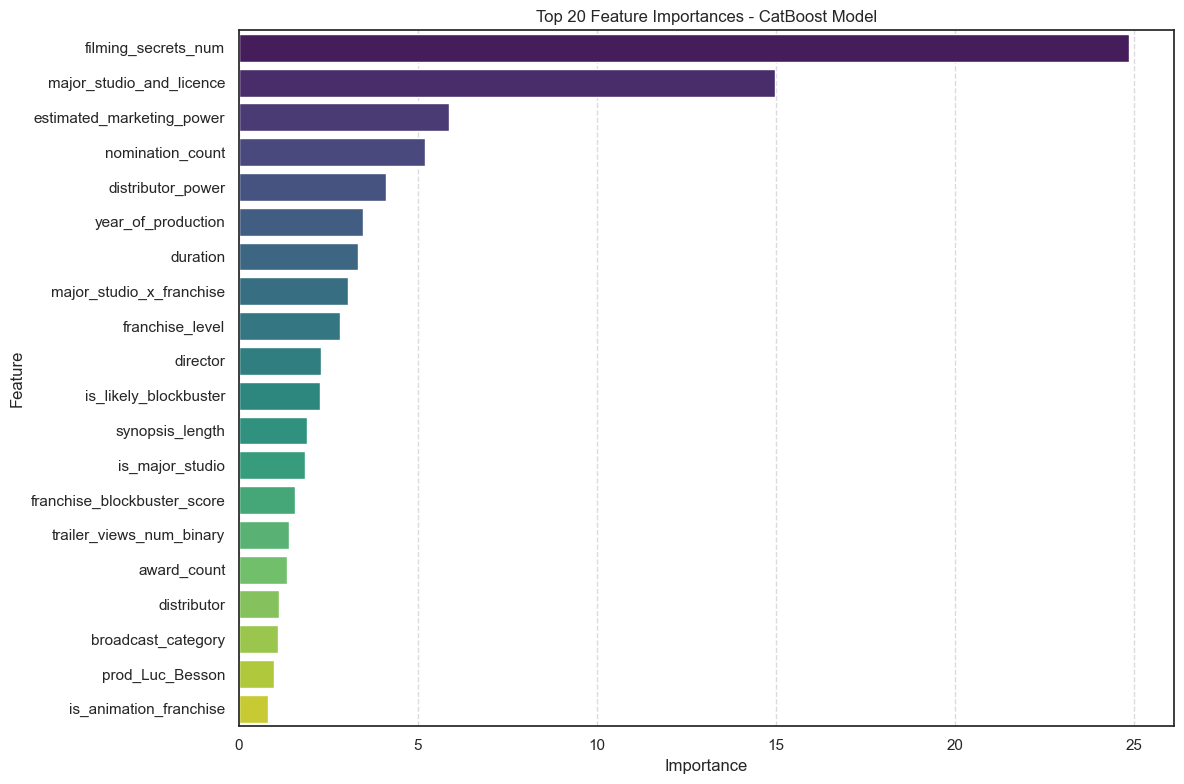

In [30]:
# Top 20 features and their importances from CatBoost model
feature_importances_cat_block = cat_model_blockbuster_2.get_feature_importance(prettified=True)
top_20_cat_block = feature_importances_cat_block.sort_values(by='Importances', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importances', y='Feature Id', data=top_20_cat_block, palette='viridis', hue='Feature Id')
plt.title('Top 20 Feature Importances - CatBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Save catboost model (optuna recommendations)

In [31]:
# cat_model_blockbuster_2.save_model('catboost_model_final.cbm')

#### Train and test model based on Train-Test-Split

In [34]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 1. Prepare features and target
X = df_model_final_cat.drop(columns=['fr_entries', 'film_title'])  # Drop target and film title
y = df_model_final_cat['fr_entries']

# 2. Train-Test Split
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# 3. Identify categorical columns
cat_cols_all = X_train_all.select_dtypes(include=["category", "object"]).columns.tolist()

# 4. Clean feature names
X_train_all.columns = X_train_all.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test_all.columns = X_test_all.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# 5. Remove duplicate columns
X_train_all = X_train_all.loc[:, ~X_train_all.columns.duplicated()]
X_test_all = X_test_all.loc[:, ~X_test_all.columns.duplicated()]

# 6. Ensure categorical columns are correctly typed
for col in cat_cols_all:
    if col in X_train_all.columns and col in X_test_all.columns:
        X_train_all[col] = X_train_all[col].astype("category")
        X_test_all[col] = X_test_all[col].astype("category")

# 7. Update cat_cols_all after cleaning (in case some columns were dropped/renamed)
cat_cols_all = [col for col in cat_cols_all if col in X_train_all.columns]

# 8. Initialize and train CatBoost model
cat_model_blockbuster_2 = CatBoostRegressor(
    iterations=808,
    learning_rate=0.1849463201769019,
    depth=8,
    l2_leaf_reg=5,
    subsample=0.7938024141563058,
    rsm=0.7498763975277183,
    random_strength=1,
    bagging_temperature=0.8160729382114458,
    grow_policy="Lossguide",
    od_type="Iter",
    od_wait=50,
    random_state=42,
    verbose=100,
)

cat_model_blockbuster_2.fit(X_train_all, y_train_all, cat_features=cat_cols_all)

# 9. Predict and evaluate
y_pred_block_2_all = cat_model_blockbuster_2.predict(X_test_all)

mae_cat_block_2 = round(mean_absolute_error(y_test_all, y_pred_block_2_all), 2)
rmse_cat_block_2 = round(root_mean_squared_error(y_test_all, y_pred_block_2_all), 2)

print(f"MAE = {mae_cat_block_2}")
print(f"RMSE = {rmse_cat_block_2}")
print("Training terminated successfully!")

# 10. Build results DataFrame
df_results_all = pd.DataFrame({
    'actual_fr_entries': y_test_all.values,
    'predicted_fr_entries': y_pred_block_2_all
})
df_results_all['error'] = df_results_all['actual_fr_entries'] - df_results_all['predicted_fr_entries']

# 11. Calculate percentage error
df_results_all['percentage_error'] = (df_results_all['error'] / df_results_all['actual_fr_entries']) * 100

# 12. Sort by absolute error
pd.set_option('display.float_format', '{:,.0f}'.format)
df_results_all = df_results_all.sort_values(by='error', key=abs, ascending=False).reset_index(drop=True)

# 13. Calculate average percentage error for blockbusters (>1M entries) and others
blockbuster_mask_all = df_results_all['actual_fr_entries'] > 1_000_000
avg_percentage_error_blockbusters_all = df_results_all[blockbuster_mask_all]['percentage_error'].mean()
avg_percentage_error_others_all = df_results_all[~blockbuster_mask_all]['percentage_error'].mean()

print(f"Average percentage error for blockbusters (>1M entries): {avg_percentage_error_blockbusters_all:,.2f}%")
print(f"Average percentage error for others (≤1M entries): {avg_percentage_error_others_all:,.2f}%")

# Final output
df_results_all.head(30)

0:	learn: 194539.9760797	total: 22.5ms	remaining: 18.1s
100:	learn: 97082.8852556	total: 1.54s	remaining: 10.8s
200:	learn: 83854.3774570	total: 2.87s	remaining: 8.66s
300:	learn: 74168.1311071	total: 4.18s	remaining: 7.04s
400:	learn: 67896.0991794	total: 5.3s	remaining: 5.38s
500:	learn: 62965.3988334	total: 6.4s	remaining: 3.92s
600:	learn: 59062.4376311	total: 7.57s	remaining: 2.61s
700:	learn: 55703.3372232	total: 8.77s	remaining: 1.34s
800:	learn: 53412.5428789	total: 10s	remaining: 87.6ms
807:	learn: 53270.3019586	total: 10.1s	remaining: 0us
MAE = 48178.71
RMSE = 146466.43
Training terminated successfully!
Average percentage error for blockbusters (>1M entries): 51.32%
Average percentage error for others (≤1M entries): nan%


/Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,actual_fr_entries,predicted_fr_entries,error,percentage_error
0,22640,"2,497,042","-2,474,402","-10,929"
1,1944022,"225,202","1,718,820",88
2,423667,"2,102,857","-1,679,190",-396
3,2251493,"779,319","1,472,174",65
4,1524218,"62,936","1,461,282",96
5,1618110,"245,356","1,372,754",85
6,3007811,"1,659,908","1,347,903",45
7,62202,"1,227,577","-1,165,375","-1,874"
8,1131341,"32,076","1,099,265",97
9,1124383,"192,269","932,114",83


In [36]:
X_train_all.head(1)

,duration,synopsis_length,award_count,nomination_count,trailer_views_num,filming_secrets_num,top_distributor_score,distributor_power,franchise_blockbuster_score,estimated_marketing_power,year_of_production,release_date_france_year,release_date_france_day,release_season,broadcast_category,duration_binary,director_binary,producers_count_binary,top_stars_count_binary,press_rating_binary,nationality_list_binary,viewer_rating_binary,trailer_views_num_binary,synopsis_binary,distributor_binary,duration_classified,synopsis_sentiment,is_sequel,synopsis_length_categorized,synopisis_sentiment_categorized,award_binary,nomination_binary,is_gaming_franchise,franchise_level,is_superhero_franchise,is_animation_franchise,is_action_franchise,is_licence,is_mcu,is_likely_blockbuster,is_major_studio,is_french_major_studio,major_studio_and_licence,french_major_and_licence,major_studio_x_franchise,is_connected_universe,director,distributor,lang_ARABIC,lang_Allemand,lang_Anglais,lang_Chinois,lang_Espagnol,lang_Fran_ais,lang_H_breu,lang_Italien,lang_Japonais,lang_Latin,lang_Mandarin,lang_Portugais,lang_Russe,nat_Allemagne,nat_Australie,nat_Belgique,nat_Canada,nat_Espagne,nat_France,nat_Grande_Bretagne,nat_Italie,nat_Japon,nat_Nouvelle_Z_lande,nat_U_S_A_,star_Andr__Dussollier,star_Beno_t_Poelvoorde,star_Brad_Pitt,star_Chris_Evans,star_Chris_Pratt,star_Christian_Clavier,star_Clovis_Cornillac,star_Daniel_Craig,star_Daniel_Radcliffe,star_Dany_Boon,star_Dwayne_Johnson,star_Emma_Watson,star_Ewan_McGregor,star_Franck_Dubosc,star_Gad_Elmaleh,star_George_Clooney,star_Gilles_Lellouche,star_Guillaume_Canet,star_G_rard_Depardieu,star_G_rard_Lanvin,star_Hugh_Jackman,star_Isabelle_Nanty,star_Jamel_Debbouze,star_Jason_Statham,star_Jean_Dujardin,star_Jean_Reno,star_Jean_Paul_Rouve,star_Johnny_Depp,star_Jos__Garcia,star_Kad_Merad,star_Keira_Knightley,star_Kristen_Stewart,star_Leonardo_DiCaprio,star_Marion_Cotillard,star_Mark_Ruffalo,star_Matt_Damon,star_Robert_Downey_Jr_,star_Robert_Pattinson,star_Rupert_Grint,star_Ryan_Reynolds,star_Steve_Carell,star_Tom_Cruise,star_Tom_Hanks,star_Vin_Diesel,star_Vincent_Cassel,star_Will_Smith,star_Zoe_Saldana,prod_Anthony_Russo,prod_Chris_Morgan,prod_Christopher_Markus,prod_Christopher_Nolan,prod_Clint_Eastwood,prod_Dany_Boon,prod_David_Koepp,prod_David_Yates,prod_Fabien_Onteniente,prod_Franck_Dubosc,prod_Gore_Verbinski,prod_Guillaume_Canet,prod_J_J__Abrams,prod_Jeff_Nathanson,prod_Joe_Russo,prod_Jon_Favreau,prod_Jonathan_Aibel,prod_Luc_Besson,prod_Melissa_Rosenberg,prod_Neal_Purvis,prod_Olivier_Baroux,prod_Peter_Jackson,prod_Philippa_Boyens,prod_Philippe_de_Chauveron,prod_Rick_Jaffa,prod_Ridley_Scott,prod_Sam_Raimi,prod_Simon_Kinberg,prod_Stephen_McFeely,prod_Steve_Kloves,prod_Steven_Spielberg,prod_Ted_Elliott,prod_Terry_Rossio,prod_Tim_Burton
8999,-1,3,-0,-0,-0,-1,-1,-0,1,-0,2023,nan,nan,Autumn,directement à la télévision,1,1,1,1,1,0,1,0,1,1,normal-film,0.0,1,long,neutral,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Josée Dayan,France 2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
